# Experiment 8: Anomaly Detection (Oddball)

**Aim**: Anomaly detection of static graph using oddball technique.

**Theory**:
Oddball extracts egonet-based features ($N_i, E_i, W_i, \lambda_i$) and finds patterns (Power Laws). Anomalies are nodes whose egonets deviate significantly from these patterns.
- **Egonet**: The subgraph induced by a node and its neighbors.
- **Patterns**: $E \propto N^\alpha$.
  - Stars: $E \approx N$
  - Cliques: $E \approx N^2$

**Implementation**:
1. Generate a synthetic graph with anomalies (Stars and Cliques).
2. Extract features for every node.
3. Plot features and identify outliers.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


C:\Users\mehta\AppData\Local\Temp\ipykernel_11496\3674256617.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.optimize import curve_fit


In [2]:
# Generate Graph: Random background + specific structures
G = nx.erdos_renyi_graph(100, 0.05, seed=42) # Background

# Inject Clique Anomaly (Nodes 100-109)
clique = nx.complete_graph(10)
G = nx.disjoint_union(G, clique)
# Connect clique to main component slightly
G.add_edge(0, 100)

# Inject Star Anomaly (Node 110 connected to 111-130)
star_center = 110
leaves = range(111, 131)
G.add_nodes_from([star_center] + list(leaves))
for leaf in leaves:
    G.add_edge(star_center, leaf)
G.add_edge(0, star_center) # Connect to main

print(f"Graph Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Graph Nodes: 131, Edges: 291


In [3]:
# Feature Extraction
features = []

for node in G.nodes():
    # Get Egonet (Node + Neighbors)
    neighbors = list(G.neighbors(node))
    egonet_nodes = neighbors + [node]
    egonet = G.subgraph(egonet_nodes)
    
    N_i = egonet.number_of_nodes()
    E_i = egonet.number_of_edges()
    
    # Weight (Unweighted graph, so W = E)
    W_i = E_i 
    
    # Eigenvalue (Leading eigenvalue of adjacency)
    try:
        if N_i > 0:
            adj = nx.adjacency_matrix(egonet).todense()
            eigenvalues = np.linalg.eigvalsh(adj)
            # Use absolute max or just largest (spectral radius)
            lambda_i = max(abs(eigenvalues))
        else:
            lambda_i = 0
    except:
        lambda_i = 0
        
    features.append({
        "node": node,
        "N": N_i,
        "E": E_i,
        "W": W_i,
        "Lambda": lambda_i
    })

import pandas as pd
df = pd.DataFrame(features)


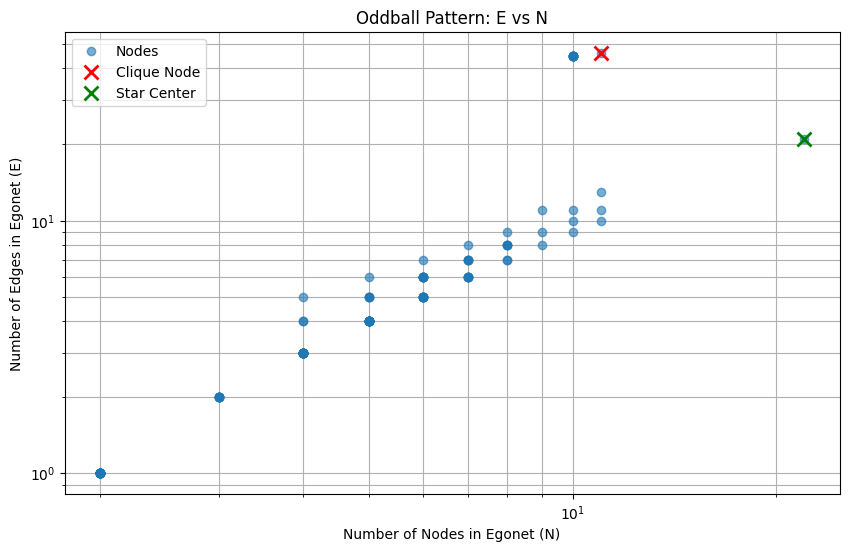

In [4]:
# Pattern Analysis: E vs N
# Filter nodes with N > 1 to avoid log(0) etc
df_filtered = df[df['N'] > 1].copy()

x = df_filtered['N']
y = df_filtered['E']

# Plot E vs N (Log-Log)
plt.figure(figsize=(10, 6))
plt.loglog(x, y, 'o', alpha=0.6, label='Nodes')

# Highlight known anomalies
# Clique: 100-109. But specifically the center node of an anomaly usually captures it best in egonet view?
# For a clique, every node's egonet is the clique.
# For a star, the center node's egonet is the star (N large, E ~ N). Leaves have small egonets.
plt.loglog(df[df['node'] == 100]['N'], df[df['node'] == 100]['E'], 'rx', markersize=10, markeredgewidth=2, label='Clique Node')
plt.loglog(df[df['node'] == 110]['N'], df[df['node'] == 110]['E'], 'gx', markersize=10, markeredgewidth=2, label='Star Center')

plt.xlabel("Number of Nodes in Egonet (N)")
plt.ylabel("Number of Edges in Egonet (E)")
plt.title("Oddball Pattern: E vs N")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


In [5]:
# Anomaly Scoring (Simplified)
# We fit a line in log-space: log(E) = alpha * log(N) + C
# Outliers are those with large residuals.
# Or simply observe:
# - Clique: E ~ N(N-1)/2 (Upper boundary)
# - Start: E ~ N (Lower boundary)
# - Random background: Somewhere in between.

# Let's define "Outlierness" as distance from the "Trend" of the background.
# Fitting line to background (Nodes < 100)
background = df_filtered[df_filtered['node'] < 100]
p = np.polyfit(np.log(background['N']), np.log(background['E']), 1)
expected_log_E = np.polyval(p, np.log(df_filtered['N']))
df_filtered['OutlierScore'] = abs(np.log(df_filtered['E']) - expected_log_E)

# Top Anomalies
top_anomalies = df_filtered.sort_values('OutlierScore', ascending=False).head(10)
print("Top Anomalies Detected:")
print(top_anomalies[['node', 'N', 'E', 'OutlierScore']])


Top Anomalies Detected:
     node   N   E  OutlierScore
104   104  10  45      1.411040
101   101  10  45      1.411040
109   109  10  45      1.411040
107   107  10  45      1.411040
106   106  10  45      1.411040
108   108  10  45      1.411040
103   103  10  45      1.411040
105   105  10  45      1.411040
102   102  10  45      1.411040
100   100  11  46      1.298993


**Observation and Conclusion**:
1. **Clique (Node 100)**: Exhibits $E \approx N^2$. It lies on the upper boundary of the E vs N plot.
2. **Star (Node 110)**: Exhibits $E \approx N$. It lies on the lower boundary.
3. **Oddball**: By plotting feature pairs like E vs N, we can visually separating "normal" dense regions from "anomalous" vertical/horizontal extremes (Stars and Cliques).
